In [2]:
import statsmodels.api as sm
import pandas as pd
import re,string
import nltk
from patsy import dmatrices
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import warnings
%pylab inline
import numpy as np
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances

Populating the interactive namespace from numpy and matplotlib


In [166]:
df = pd.read_csv("edmunds_comments.csv",encoding='iso-8859-1')
df.post = df.post.astype(str)
print(df.dtypes)
df.head()

date        object
username    object
post        object
quotes      object
dtype: object


,date,username,post,quotes
0,b'September 7',b'dino001',b'If they keep it around in next four-five yea...,"b""The lease rate is the factor that stops me c..."
1,b'September 7',b'circlew',b'2018 430i Gran Coupe',"b""show previous quotes\n\n\nThe Stinger is too..."
2,b'September 8',b'qbrozen',"b""The lease rate is the factor that stops me c...",b''
3,b'September 9',b'FlightNurse2',"b""circlew said:\nThe lease rate is the factor ...","b'Again, the local dealer are hopeless at best..."
4,b'September 9',b'roadburner',"b""'17 F150 Crew 2.7; '67 Coronet R/T; '14 Town...","b'Thanks, but I am more than aware of the dist..."


In [167]:
#clean punctuation and white spaces
df["post_clean"] = df.post.apply(lambda x:re.sub(r"[^a-zA-Z0-9\s]", " ", x.lower()))
df["post_clean"] = df.post_clean.apply(lambda x:re.sub(r"\n", " ", x.lower()))
df["post_clean"] = df.post_clean.apply(lambda x:re.sub(r'\s+', ' ', x))

In [168]:
#removing stop words
stop = set(stopwords.words('english'))
df['post_clean'] = df.post_clean.apply(lambda x: [word for word in x.split() if word not in stop])

In [163]:
df.head()

,date,username,post,quotes,post_clean
0,x,x,x,x,[x]
1,b'September 7',b'dino001',b'If they keep it around in next four-five yea...,"b""The lease rate is the factor that stops me c...","[b, keep, around, next, four, five, years, thi..."
2,b'September 7',b'circlew',b'2018 430i Gran Coupe',"b""show previous quotes\n\n\nThe Stinger is too...","[b, 2018, 430i, gran, coupe]"
3,b'September 8',b'qbrozen',"b""The lease rate is the factor that stops me c...",b'',"[b, lease, rate, factor, stops, cold, taking, ..."
4,b'September 9',b'FlightNurse2',"b""circlew said:\nThe lease rate is the factor ...","b'Again, the local dealer are hopeless at best...","[b, circlew, said, nthe, lease, rate, factor, ..."


### Replacing model with make in the corpus

In [7]:
#importing model list
car_models = pd.read_csv("car_models_curated_V2.csv", )
car_models.head()
car_models.dtypes

make      object
model1    object
dtype: object

In [8]:
car_models["model1"]=car_models["model1"].astype(str)
car_models["make"] = car_models["make"].apply(lambda x:re.sub(r"[^\w\s]", "", x.lower()))
car_models["model1"] = car_models["model1"].map(lambda x:re.sub(r"[^\w\s]", "", x.lower()))

In [9]:
#converting into dictionary
#This will help in identifying make for corresponding model
car_dict = car_models.set_index('model1').transpose().to_dict()
model = "beetle"
car_dict[model]['make']

C:\Users\abhin\Anaconda2\envs\Python3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  This is separate from the ipykernel package so we can avoid doing imports until


'volkswagen'

In [10]:
#replace model with make
model1 = set(car_models["model1"])
df["post_c2"] = df.post_clean.map(lambda x: [car_dict[i]['make'] if i in model1 else i for i in x])

In [11]:
#lemmatizing
#need to get POS for lemmatizing
#create a function that would return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
#wnl = WordNetLemmatizer()
#df['post_lema'] = df.post_clean.apply(lambda x: [wnl.lemmatize(word) for word in x])

### Checking frequency for all values

In [12]:
#getting frequency distribution
car_posts = df['post_c2'].sum()

In [13]:
all_words = nltk.FreqDist(car_posts)
rslt_all = pd.DataFrame.from_dict(all_words,orient='index').reset_index()
rslt_all.columns = ['word','frequency']

### Most popular brands (all)

In [14]:
rslt_all[rslt_all['word'].isin(car_models["make"])].nlargest(10,'frequency')

,word,frequency
33,bmw,239
156,acura,208
212,audi,159
117,polaris,121
13,kia,111
209,honda,110
793,volkswagen,57
159,kymco,51
114,triumph,41
4,ford,39


### Taking unique values (using set)

In [15]:
cars_unique = df.post_c2.map(lambda x:[ "".join(word) for word in sorted(set(x))]).sum() 

In [16]:
unique_words = nltk.FreqDist(cars_unique)
rslt_unique = pd.DataFrame.from_dict(unique_words,orient='index').reset_index()
rslt_unique.columns = ['word','frequency']

### Most popular brands (unique)

In [17]:
rslt_unique[rslt_unique['word'].isin(car_models["make"])].nlargest(10,'frequency')

,word,frequency
7,bmw,120
145,acura,83
111,polaris,79
197,audi,78
219,honda,57
33,kia,52
160,kymco,44
817,volkswagen,37
124,triumph,31
101,cub cadet,30


### Calculate Lift Ratio

Identify top 10 brands by frequency. From the posts, calculate lift ratios for associations between the brands. You will have to write a script to do this task). Show the brands on a multi-dimensional scaling (MDS) map (use a Python script for MDS, there are multiple scripts available on the Internet). 

In [29]:
def ratio(a, b):
    a = float(a)
    b = float(b)
    if b == 0:
        return a
    return ratio(b, a % b)

#returns a string with ratio
def get_ratio(a, b):
    r = ratio(a, b)
    return "%s" % float((a/r) / (b/r))

In [121]:
#selecting top brands
def create_mds(num_brands):
    top_brands = rslt_unique[rslt_unique['word'].isin(car_models["make"])].nlargest(num_brands,'frequency')
    car_make_df = pd.DataFrame()
    car_make_df['brand1'] = [x for x in top_brands.word for y in top_brands.word] #if x!=y]
    car_make_df['brand2'] = [y for x in top_brands.word for y in top_brands.word] #if x!=y]
    car_make_df['ratio'] = [get_ratio(x,y) for x in top_brands.frequency for y in top_brands.frequency] #if x!=y]
    xdf = car_make_df.pivot(index="brand1",columns="brand2",values="ratio")
    mds = MDS(n_components=2,random_state=6)
    similarities = euclidean_distances(xdf.values.astype(np.float32))
    res = mds.fit(xdf.values.astype(np.float64))
    return(xdf,res)   

In [101]:
def plot_mds(xdf,res):
    plt.figure(figsize=(12,8))
    plt.scatter(res.embedding_[:,0],res.embedding_[:, 1])

    #plot the brand name labels
    for label, x, y in zip(xdf.columns.values, res.embedding_[:, 0], res.embedding_[:, 1]):
        plt.annotate(label,xy = (x, y), xytext = (-20, 20),textcoords = 'offset points', ha = 'left', va = 'bottom',
                     bbox = dict(boxstyle = 'round,pad=.2', fc = 'orange', alpha = 0.6),
                     arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
        plt.show()

### Insights

C:\Users\abhin\Anaconda2\envs\Python3\lib\site-packages\sklearn\manifold\mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


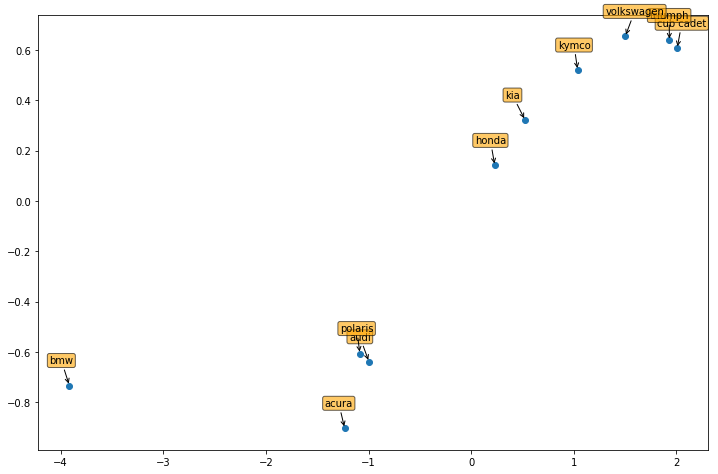

In [124]:
# plot MDS top 10
lift_df, results = create_mds(num_brands = 10)
plt_mds(lift_df, results)

C:\Users\abhin\Anaconda2\envs\Python3\lib\site-packages\sklearn\manifold\mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


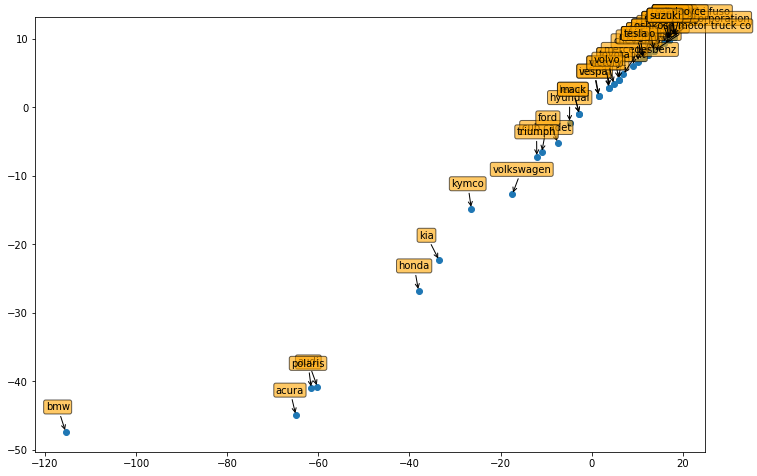

In [125]:
# plot MDS top 50
lift_df, results = create_mds(num_brands = 50)
plt_mds(lift_df, results)

### Frequently mentioned attributes for cars

Now pick the 5 most frequently mentioned brands. Which attributes are most strongly associated with which of these 5 brands? 

### While BMW has claimed that they are the “ultimate driving machine”, is that how people feel on Edmunds? Show your analysis.   

### Advice to (i) product manager, and (ii) marketing/advertising manager of these brands based on attribute relations

### Most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?